Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
---

step 2. Inspect Data and understand relationships

In [33]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

engine=create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session=sessionmaker(bind=engine)
session=Session()

In [34]:
#Inspect the table names
from sqlalchemy import inspect
inspector=inspect(engine)
print(inspector.get_table_names())

2019-04-16 20:46:41,154 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-16 20:46:41,156 INFO sqlalchemy.engine.base.Engine ()
2019-04-16 20:46:41,162 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-16 20:46:41,163 INFO sqlalchemy.engine.base.Engine ()
2019-04-16 20:46:41,167 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-16 20:46:41,168 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


inspecting the table names and see if there is anything different from ERD diagram: 1)Employee vs Employees 2)EmployeeTerritory vs EmployeeTerritories ... it seems all the tables are singlar vs plural in the ERD table

In [35]:
#Query relevant field from OrderDetail Table
import pandas as pd

df_OD=pd.read_sql_query("select * from OrderDetail", engine)
df_OD.head()

2019-04-16 20:46:41,191 INFO sqlalchemy.engine.base.Engine select * from OrderDetail
2019-04-16 20:46:41,193 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [36]:
df_OD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [37]:
df_OD.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


Step 3. Construct Hypothesis:

Null Hypothesis (H0): Discount has no statistical significant relationship to number of products customer orders. mu_fp=mu_disc (mu_fp is the mean of full price quantity. mu_disc is the mean of discount quantity.)

Alternative(H-alpha): Discount has a statistically significant impact to the number of products customer orders. Alpha is set to 0.05. mu_fp!=mu_disc

p<α : Reject the Null Hypothesis and accept the Alternative Hypothesis
p>=α : Fail to reject the Null Hypothesis.



In [38]:
# data set where there is no discount or full price (fp), or control
df_fp=pd.read_sql_query("select * from OrderDetail where Discount=0", engine)
df_fp.head()

2019-04-16 20:46:41,467 INFO sqlalchemy.engine.base.Engine select * from OrderDetail where Discount=0
2019-04-16 20:46:41,469 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [39]:
# data set where there is discount (disc), or experiement
df_disc=pd.read_sql_query("select * from OrderDetail where Discount!=0", engine)
df_disc.head()

2019-04-16 20:46:41,521 INFO sqlalchemy.engine.base.Engine select * from OrderDetail where Discount!=0
2019-04-16 20:46:41,525 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


/Users/Alex/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


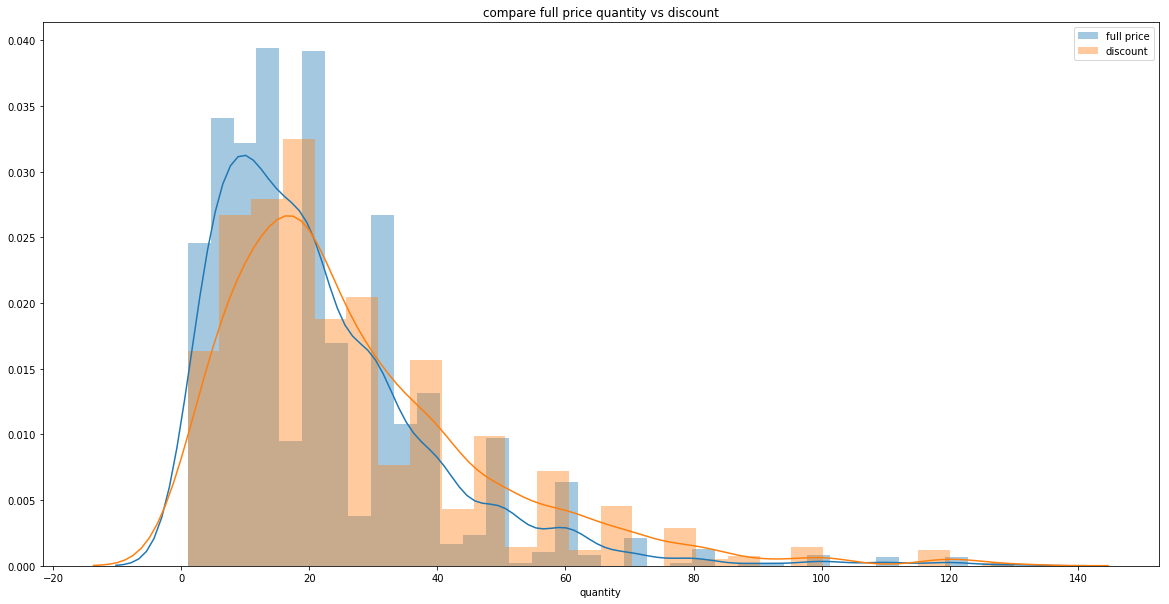

In [40]:
#check normality and what do two sets of data look like visually
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))
sns.distplot(df_fp.Quantity, label='full price')
sns.distplot(df_disc.Quantity, label='discount')
plt.title('compare full price quantity vs discount')
plt.xlabel('quantity')
plt.legend()


- Not a normal distribution. Most orders are in single unit. one side skewed distribution with long tail.
- small difference in mean and standard deviation between full price vs discount quantity.

In [41]:
#Calculating T-value
import numpy as np

def variance(sample):
    sample_mean=np.mean(sample)
    return sum([(i-sample_mean)**2 for i in sample])

def sample_variance(sample1, sample2):
    n_1, n_2=len(sample1), len(sample2)
    var_1, var_2=variance(sample1), variance(sample2)
    return (var_1+var_2)/(n_1+n_2-2)

def twosample_t(exp, control):
    exp_mean, control_mean=np.mean(exp), np.mean(control)
    sample_var=sample_variance(exp, control)
    n_e, n_c=len(exp), len(control)
    num= exp_mean-control_mean
    denom=np.sqrt(sample_var*(1/n_e+1/n_c))
    return num/denom

In [42]:
t_stat=twosample_t(df_disc.Quantity, df_fp.Quantity)
t_stat

6.478563196294904

In [43]:
#Calculating p-value
from scipy import stats
stats.t.sf(abs(t_stat), len(df_disc.Quantity)+len(df_fp.Quantity)-1)*2

1.1439815448583801e-10

In [44]:
#try with t-test function, same result
stats.ttest_ind(df_disc.Quantity, df_fp.Quantity)

Ttest_indResult(statistic=6.4785631962949015, pvalue=1.1440924523215966e-10)

p< alpha: reject null hypothesis. there is a statistical signficance between discount and quantity purchase

In [45]:
#try cohen d test
def Cohen_d(sample1, sample2):
    diff=sample1.mean()-sample2.mean()
    n1,n2=len(sample1), len(sample2)
    var1, var2=sample1.var(), sample2.var()
    pooled_var=(n1*var1+n2*var2)/(n1+n2)
    d=diff/np.sqrt(pooled_var)
    return d
Cohen_d(df_disc.Quantity, df_fp.Quantity)

0.2862724481729283

cohen d value seems to suggest that there is a small to medium effect difference.

In [46]:
#how many different level of discount are there?
df_OD.Quantity.groupby(df_OD.Discount).describe()
#ignore 1%, 2%, 3%,4%,6% due to insufficient data 

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


In [47]:
#Tukey test to see what discount % is statistically significant
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

tukey=MultiComparison(df_OD.Quantity, df_OD.Discount)
result=tukey.tukeyhsd()
print(result)
print(tukey.groupsunique)


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

Conclusion: As we can see from the Tukey test, only 5%, 15%, 20% and 25% are significant. among those, the meandiff in 15% is the greatest, so it is saying that 15% makes the biggest difference, however it is marginal. If the company's KPI is to sell as much quantity as possible, then 15% is recommended. However, without knowing the net profit margin after discount (or amount of mark up before discount), it is difficult to make a recommendation to what discount should be applied.

Question 2: Is there a signifant different in the basket value (ie total sales revenue per order) when there is a discount? 
---
H0: total sales per order is not influenced by any discount. ie. mu (total sales per order in the absence of any discount) = mu(total sales per order with presence of any discount)

H1: total sales per order is influenced by presence of any discount. ie. mu (total sales per order in the absence of any discount) != mu(total sales per order with presence of any discount)

In [48]:
#get total transaction value per order
df_OD['Total Order Value']=df_OD.Quantity* df_OD.UnitPrice*(1-df_OD.Discount)

In [49]:
df_OD.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Total Order Value
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [50]:
#drop the columns that are no longer in use
df_OD1=df_OD.copy()
df_OD1.drop(['UnitPrice', 'Quantity', 'ProductId','Id'],axis=1, inplace=True)
df_OD1.head()

,OrderId,Discount,Total Order Value
0,10248,0.0,168.0
1,10248,0.0,98.0
2,10248,0.0,174.0
3,10249,0.0,167.4
4,10249,0.0,1696.0


In [51]:
#group by OrderID, and seperate the control (no presence of Discount) vs experiment (with presence of Discount) data set
df_OD2=df_OD1.groupby(['OrderId']).sum()
df_OD2_fp=df_OD2.loc[(df_OD2.Discount==0)]
df_OD2_disc=df_OD2.loc[(df_OD2.Discount!=0)]
#just to check if the numbers adds up
print(len(df_OD2_fp))
print(len(df_OD2_disc))
print(len(df_OD2))

450
380
830


/Users/Alex/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


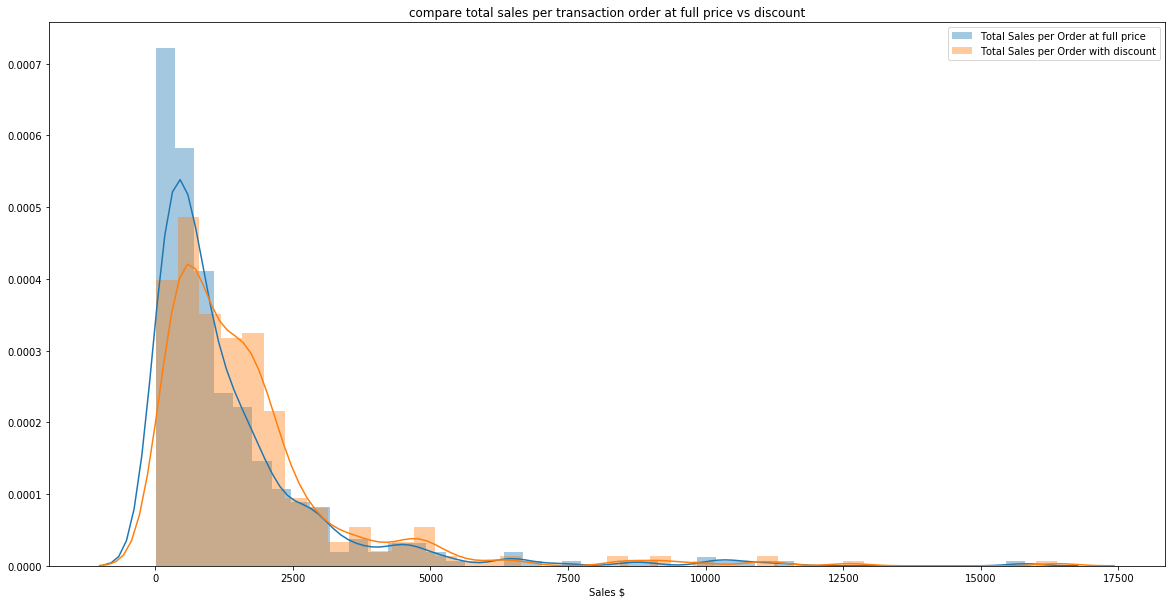

In [52]:
#Visually see distribution
plt.figure(figsize=(20,10))
sns.distplot(df_OD2_fp['Total Order Value'], label='Total Sales per Order at full price')
sns.distplot(df_OD2_disc['Total Order Value'], label='Total Sales per Order with discount')
plt.title('compare total sales per transaction order at full price vs discount')
plt.xlabel('Sales $')
plt.legend()

The graph is suggesting that Total sales per Order/transaction is very similar between full price vs discounts, possibly slightly skewed higher value when there is a presence of discount. 

In [53]:
#calculating for pvalue
stats.ttest_ind(df_OD2_disc['Total Order Value'], df_OD2_fp['Total Order Value'])

Ttest_indResult(statistic=2.5523167882461726, pvalue=0.010879379364521458)

In [54]:
#try Cohen D test
Cohen_d(df_OD2_disc['Total Order Value'], df_OD2_fp['Total Order Value'])

0.1778169538640482

Conclusion: pvalue suggests that there is a statistical significance in the total purchase value when there is a presence of discount. (ie people are buying more per transaction.)

Cohen D test number suggests that the difference in the total transaction value is small, despite that there is a statistic significance when there is a presence of discount.

Business implication: The total sales revenue per order does seem to increase when there is presence of discount, but not 	significant. This suggests that if the company’s KPI is to increase top line revenue, then they should always be running some sort of discount. However, if the KPI is to increase net profitability, further investigation is needed.


Question3: Is the average sales value per transaction higher in UK than the rest of the world?
---
H0: mu of UK sales value per transaction = mu of sales value per transaction other countries

H1: mu of UK sales value per transaction != mu of sales value per transaction of other countries

In [55]:
#Query relevant fields based on order ID and Customer ID
df_p=pd.read_sql_query('''
        select od.UnitPrice, od.Quantity, od.Discount, c.Country
        from OrderDetail od
        join [Order] o
        on o.Id=od.OrderId
        join Customer c
        on o.CustomerId=c.Id
        ''', engine)
df_p.head()

2019-04-16 20:46:44,885 INFO sqlalchemy.engine.base.Engine 
        select od.UnitPrice, od.Quantity, od.Discount, c.Country
        from OrderDetail od
        join [Order] o
        on o.Id=od.OrderId
        join Customer c
        on o.CustomerId=c.Id
        
2019-04-16 20:46:44,890 INFO sqlalchemy.engine.base.Engine ()


,UnitPrice,Quantity,Discount,Country
0,14.0,12,0.0,France
1,9.8,10,0.0,France
2,34.8,5,0.0,France
3,18.6,9,0.0,Germany
4,42.4,40,0.0,Germany


In [56]:
#calculate sales value per order
df_p['SalesValue']=df_p.UnitPrice * df_p.Quantity*(1-df_p.Discount)
df_p.drop(['UnitPrice','Quantity', 'Discount'], axis=1, inplace=True)
df_p.head()

,Country,SalesValue
0,France,168.0
1,France,98.0
2,France,174.0
3,Germany,167.4
4,Germany,1696.0


In [57]:
#check if the numbers looks alright
df_p.groupby(['Country']).SalesValue.mean()

Country
Argentina       202.560870
Austria        1024.030708
Belgium         604.015268
Brazil          498.210301
Canada          669.283867
Denmark         710.022228
Finland         348.334306
France          455.670986
Germany         702.087297
Ireland         908.725545
Italy           297.550094
Mexico          301.056364
Norway          358.446875
Poland          220.746875
Portugal        382.412083
Spain           333.022222
Sweden          561.805567
Switzerland     609.474212
UK              436.824519
USA             697.683553
Venezuela       481.446008
Name: SalesValue, dtype: float64

In [58]:
#seperate into 2 data set, one with UK only, and the other for the rest of the world
df_p_UK=df_p[df_p['Country']=='UK']
df_p_rest=df_p[df_p['Country']!='UK']
df_p_UK.head()

,Country,SalesValue
109,UK,240.0
110,UK,239.4
178,UK,156.8
179,UK,360.0
183,UK,154.0


In [59]:
#calculate p-value
stats.ttest_ind(df_p_UK.SalesValue, df_p_rest.SalesValue)

Ttest_indResult(statistic=-1.8997319606173722, pvalue=0.05760676372336533)

Conclusion: pvalue is greater than alpha 0.05. Hence we accept the null hypothesis that there is no stastical signficant evidence that UK average sales value per order is different from the rest of the world. From a business prospective, the company probably shouldn't spend above normal budget in UK marketing, as the purchasing power from UK seems to be average or inline with the rest of the world.


Question 4: is there a difference in sales value per order when it is executed by a younger employee vs an older employee?
-----
H0: mu of sales value per order executed by a younger employee = mu of sales value per order executed by an older employee (young <30, older>=30)

H1: mu of sales value per order executed by a younger employee != mu of sales value per order executed by an older employee


In [60]:
#extracts relevant columns matching on order ID and Employee ID
df_OD_E=pd.read_sql_query('''
        select od.OrderId, od.Quantity, od.UnitPrice, od.Discount,
        e.BirthDate, e.Id
        from OrderDetail od
        join [Order] o on o.Id = od.OrderId 
        join Employee e on o.EmployeeID= e.Id
        ''', engine)
df_OD_E.head()

2019-04-16 20:46:45,127 INFO sqlalchemy.engine.base.Engine 
        select od.OrderId, od.Quantity, od.UnitPrice, od.Discount,
        e.BirthDate, e.Id
        from OrderDetail od
        join [Order] o on o.Id = od.OrderId 
        join Employee e on o.EmployeeID= e.Id
        
2019-04-16 20:46:45,130 INFO sqlalchemy.engine.base.Engine ()


,OrderId,Quantity,UnitPrice,Discount,BirthDate,Id
0,10248,12,14.0,0.0,1987-03-04,5
1,10248,10,9.8,0.0,1987-03-04,5
2,10248,5,34.8,0.0,1987-03-04,5
3,10249,9,18.6,0.0,1995-07-02,6
4,10249,40,42.4,0.0,1995-07-02,6


In [61]:
#calculate the toal order value
df_OD_E['Total Order Value']=df_OD_E.Quantity* df_OD_E.UnitPrice*(1-df_OD_E.Discount)
df_e=df_OD_E.copy()
df_e.drop(['UnitPrice', 'Quantity', 'OrderId','Discount'],axis=1, inplace=True)
df_e.head()

,BirthDate,Id,Total Order Value
0,1987-03-04,5,168.0
1,1987-03-04,5,98.0
2,1987-03-04,5,174.0
3,1995-07-02,6,167.4
4,1995-07-02,6,1696.0


In [62]:
df_e.groupby(['Id'])['Total Order Value'].sum()
df_e.head()

,BirthDate,Id,Total Order Value
0,1987-03-04,5,168.0
1,1987-03-04,5,98.0
2,1987-03-04,5,174.0
3,1995-07-02,6,167.4
4,1995-07-02,6,1696.0


In [63]:
#check if the birth date are in the date time format
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
BirthDate            2155 non-null object
Id                   2155 non-null int64
Total Order Value    2155 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 50.6+ KB


In [64]:
#convert birth date from object to date time format 
df_e.BirthDate = pd.to_datetime(df_e.BirthDate, format='%Y-%m-%d')
df_e.head()

,BirthDate,Id,Total Order Value
0,1987-03-04,5,168.0
1,1987-03-04,5,98.0
2,1987-03-04,5,174.0
3,1995-07-02,6,167.4
4,1995-07-02,6,1696.0


In [65]:
#check if the date has been converted to the right format
df_e.dtypes

BirthDate            datetime64[ns]
Id                            int64
Total Order Value           float64
dtype: object

In [66]:
#Turn birth date to age in order to seperate the data set later between younger (<30yr) and older (>=30yr)
df_e.BirthDate= 2019-df_e.BirthDate.dt.year

In [67]:
#check if the dataset makes sense
df_e.groupby(['Id']).mean()

,BirthDate,Total Order Value
Id,,
1,39,556.833636
2,35,691.028029
3,24,631.815710
4,50,554.502014
5,32,587.968226
6,24,439.959104
7,27,707.774063
8,29,487.931837
9,21,722.505294


In [68]:
#seperate data set between younger employee (under 30) and older employee (over 30)
df_e_under= df_e[df_e['BirthDate']<30]
df_e_over= df_e[df_e['BirthDate']>=30]

In [69]:
#Calculate p-value
stats.ttest_ind(df_e_over['Total Order Value'], df_e_under['Total Order Value'])

Ttest_indResult(statistic=0.031421307002388994, pvalue=0.974936461396682)

pvalue is greater than alpha, hence we accept our null hypothesis there is no difference in sales value per order when it is executed by a younger employee vs an older employee.

/Users/Alex/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


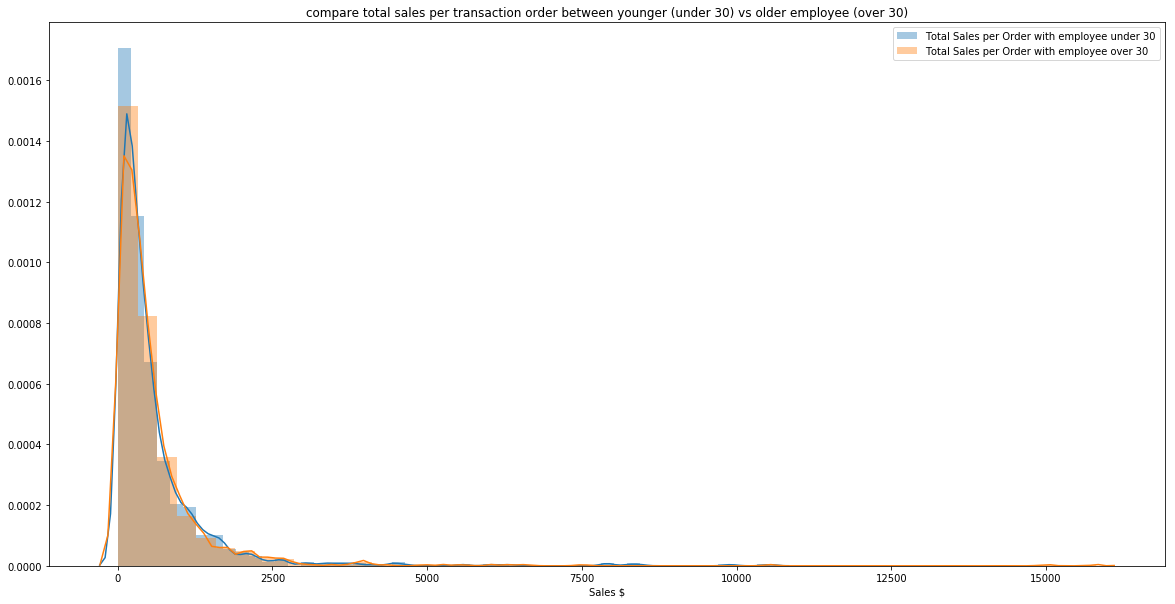

In [70]:
#let's check the distribution graph just to see if it makes visual sense
plt.figure(figsize=(20,10))
sns.distplot(df_e_under['Total Order Value'], label='Total Sales per Order with employee under 30')
sns.distplot(df_e_over['Total Order Value'], label='Total Sales per Order with employee over 30')
plt.title('compare total sales per transaction order between younger (under 30) vs older employee (over 30)')
plt.xlabel('Sales $')
plt.legend()

Conclusion: There is no statistical signficance between order values when it is executed by a younger employee vs an older employee. From business' prospective, if it is cheaper to hire younger employee, then they should do so. 